In [1]:
%matplotlib inline
#general imports
import os
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import pylab
import pandas as pd
from datetime import datetime, time, timedelta
import tables
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import time, datetime, timedelta
from scipy.linalg import eigh, norm

#text imports
import gensim
from gensim.models import word2vec
import multiprocessing
cores = multiprocessing.cpu_count()
import random
assert gensim.models.word2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

#images imports
import tensorflow as tf
from scipy.misc import imread, imresize

/Users/christophelanternier/anaconda/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
import common.p_vgg16 as p_vgg16
import common.p_cca as p_cca
import common.p_w2v as p_w2v

In [3]:
#get all usefull paths

MODEL_PATH = os.path.join('model')+os.sep
IMAGES_PATH = os.path.join('images', 'train2014')+os.sep

## Choose setting

In [4]:
text_features = 'w2v' # can be set to 'GLOVE' to test the glove word representation
image_features = 'fc2' # choose which layer of vgg16 is going to be used to extract features
train_test_split = 50000
reg = 0.001 # this value is recommended by the paper
n_components = 50 # experiments have shown this value to be optimal

## Get features

#### Initialize text features extractors

In [5]:
if text_features == 'GLOVE':
    #load glove dictionnary
    model = p_w2v.loadGloveModel('data/glove.6B/glove.6B.300d.txt')
else:
    #Load pre-trained word2vec NN, takes a bit of time
    model = gensim.models.Word2Vec.load_word2vec_format(MODEL_PATH+'GoogleNews-vectors-negative300.bin', binary=True)  

In [6]:
# initialize COCO api for caption annotations
dataType='train2014'
annFile = 'annotations/captions_%s.json'%(dataType)
coco_caps=COCO(annFile)
imgIds = coco_caps.getImgIds()
catFile = 'annotations/instances_%s.json'%(dataType)
coco_insts = COCO(catFile)
catIds = coco_insts.getCatIds()

#Get Category retrieval dictionnary
dic_img_cat = {}
for imgId in imgIds:
    dic_img_cat[imgId] = []
for catId in catIds:
    imgIds_cat = coco_insts.getImgIds(catIds=catId)
    for imgId in imgIds_cat:
        dic_img_cat[imgId] += [coco_insts.loadCats(catId)[0]['name']]

loading annotations into memory...
Done (t=1.98s)
creating index...
index created!
loading annotations into memory...
Done (t=18.44s)
creating index...
index created!


#### Initialize image features extractors

In [7]:
#initialize CNN
sess = tf.Session()
imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
vgg = p_vgg16.VGG16(imgs, MODEL_PATH + 'vgg16_weights.npz', sess)

0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
14 conv4_1_W (3, 3, 256, 512)
15 conv4_1_b (512,)
16 conv4_2_W (3, 3, 512, 512)
17 conv4_2_b (512,)
18 conv4_3_W (3, 3, 512, 512)
19 conv4_3_b (512,)
20 conv5_1_W (3, 3, 512, 512)
21 conv5_1_b (512,)
22 conv5_2_W (3, 3, 512, 512)
23 conv5_2_b (512,)
24 conv5_3_W (3, 3, 512, 512)
25 conv5_3_b (512,)
26 fc6_W (25088, 4096)
27 fc6_b (4096,)
28 fc7_W (4096, 4096)
29 fc7_b (4096,)
30 fc8_W (4096, 1000)
31 fc8_b (1000,)


## Load Features

In [8]:
hdf5_path = "data/data_"+image_features+"_all.hdf5"
read_hdf5_file = tables.open_file(hdf5_path, mode='r')
# Here we slice [:] all the data back into memory, then operate on it
text_data = read_hdf5_file.root.text[:]
image_data = read_hdf5_file.root.image[:]
cat_data = read_hdf5_file.root.cat[:]

read_hdf5_file.close()

if text_features == 'GLOVE':
    
    hdf5_path = "data/data_glove.hdf5"
    read_hdf5_file = tables.open_file(hdf5_path, mode='r')
    # Here we slice [:] all the data back into memory, then operate on it
    text_data = read_hdf5_file.root.text[:]
    read_hdf5_file.close()

In [9]:
data = [text_data, image_data, cat_data]
data_train = [text_data[train_test_split:], image_data[train_test_split:], cat_data[train_test_split:]]
data_test = [text_data[:train_test_split], image_data[:train_test_split], cat_data[:train_test_split]]

## Perform CCA

In [10]:
cca = p_cca.CCA(model, coco_caps, vgg, sess, reg=reg, n_components=n_components)
cca.train(data) # Here we train on all data in order to have the maximum number of images to query

## Perform T2I

In [70]:
sentence = "dog dog skateboard"
closest_ids = cca.T2I(sentence, neighbors_number=36)

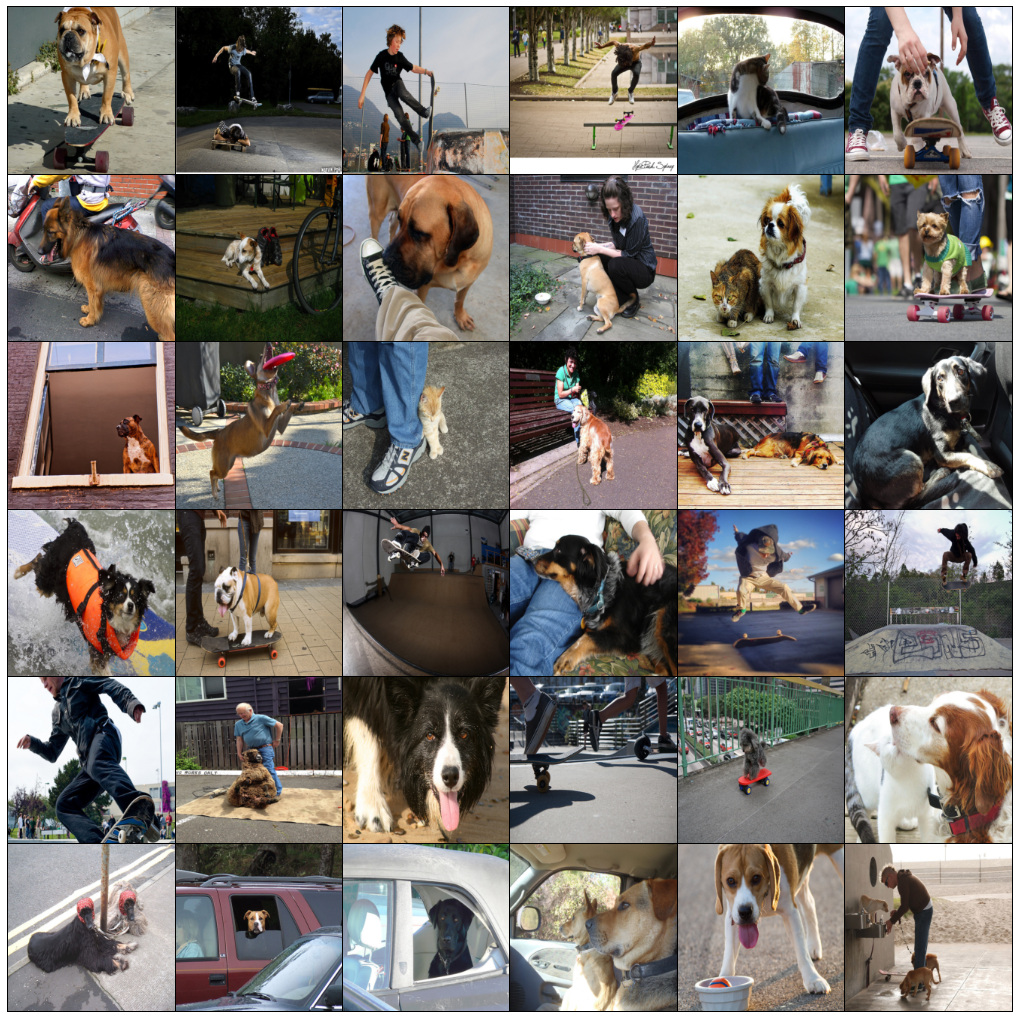

In [71]:
filename = 'images/results/6/'+sentence+'-'+str(image_features)+'-'+str(cca.reg)+'-'+str(cca.n_components)+'.png'
result_images, result_captions = cca.getT2Iresults(closest_ids, filename)

## Precision recall

In [14]:
id_cats = [57,82,17,41,5]
id_cats = [57,41,5]

for id_cat in id_cats:
    print coco_insts.loadCats(id_cat)[0]['name']

carrot
skateboard
airplane


normal
carrot 1186


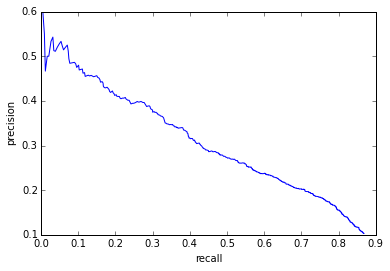

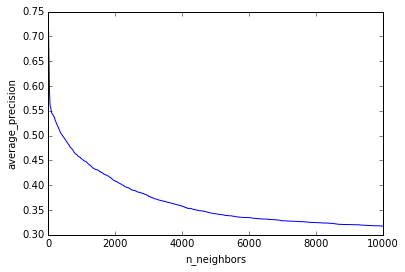

skateboard 2511


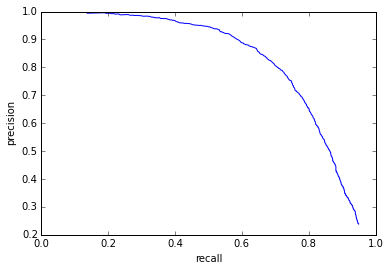

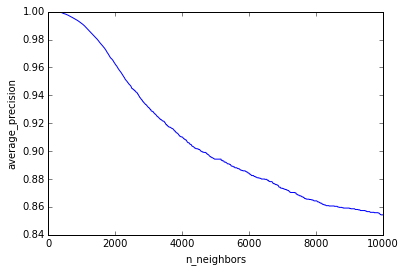

airplane 2243


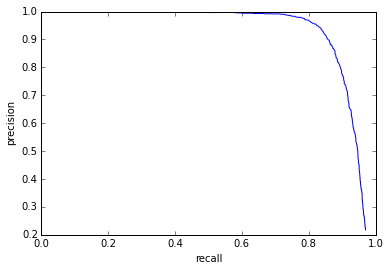

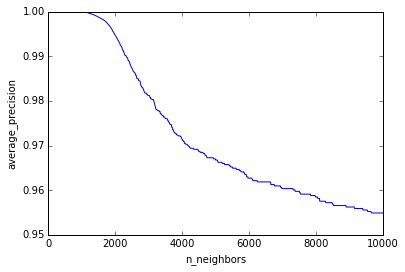

distance
carrot 1186


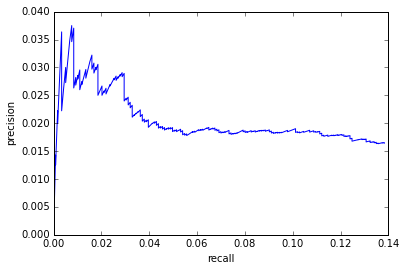

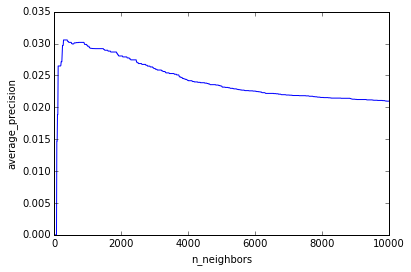

skateboard 2511


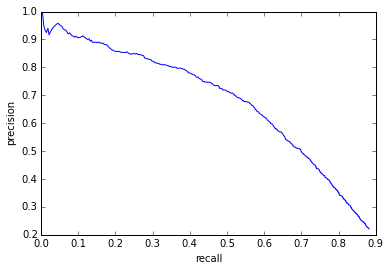

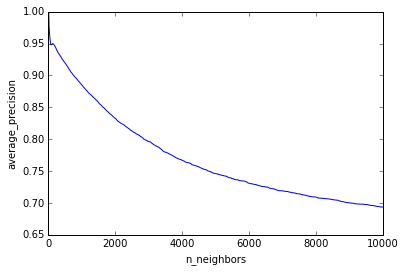

airplane 2243


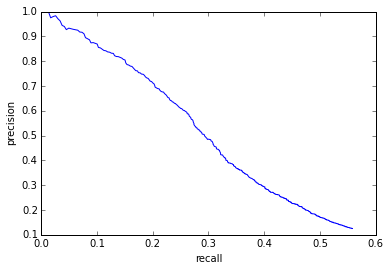

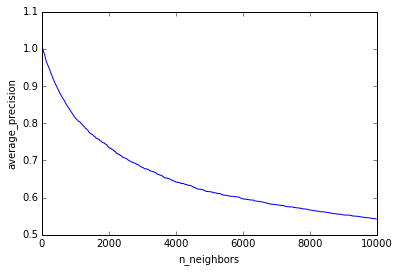

two-view
carrot 1186


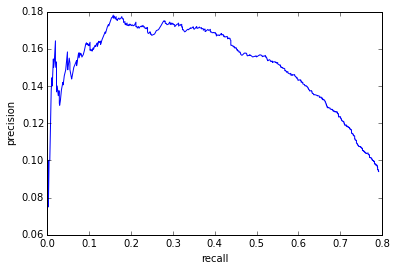

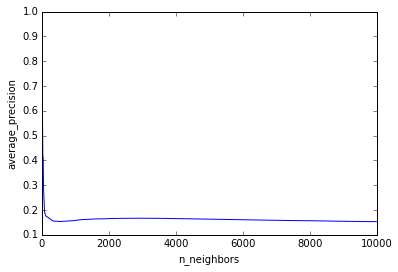

skateboard 2511


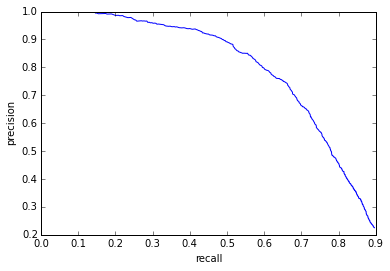

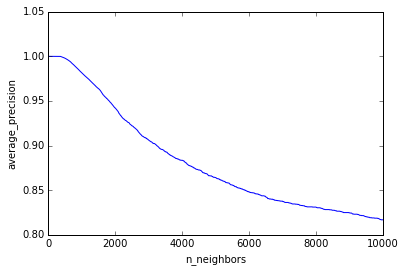

airplane 2243


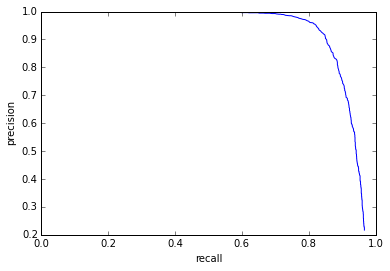

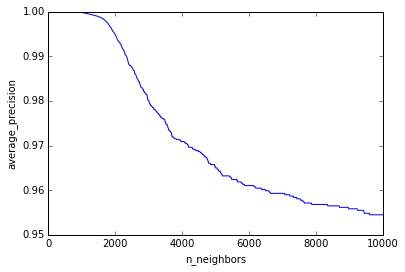

Loading Glove Model
Done. 400000  words loaded!
GLOVE
carrot 1186


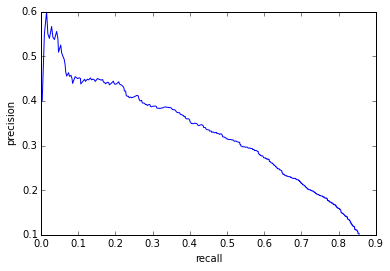

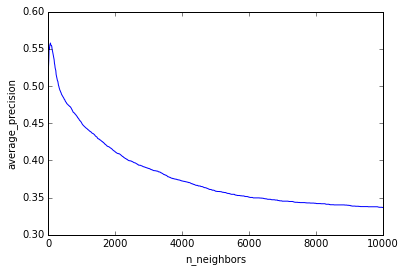

skateboard 2511


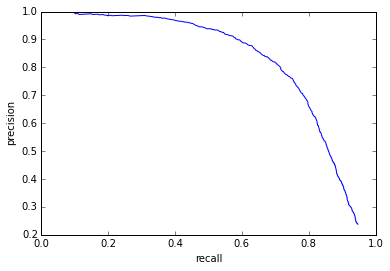

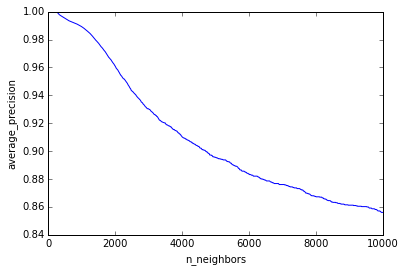

airplane 2243


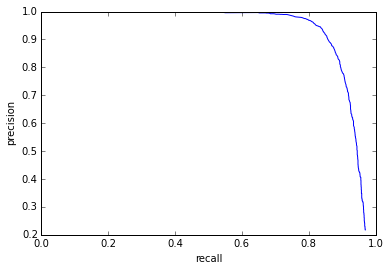

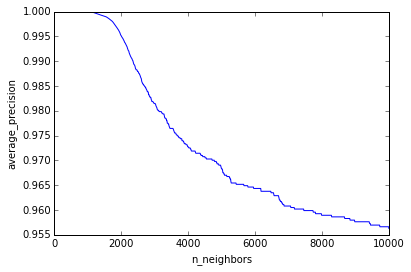

In [95]:
n_neighbors = 10000
results = {}
for id_cat in id_cats:
    results[id_cat] = {}
for test in ['normal','distance', 'two-view', 'GLOVE']:
    
    if test  == 'normal':
        method = 'similarity'
    elif test == 'distance':
        method = 'distance'
    elif test == 'two-view':
        method = 'similarity'
        data = [text_data, image_data]
        data_train = [text_data[:train_test_split], image_data[:train_test_split]]
        cca = p_cca.CCA(model, coco_caps, vgg, sess, reg=reg, n_components=n_components)
        cca.train(data)
    elif test == 'GLOVE':
        model = p_w2v.loadGloveModel('data/glove.6B/glove.6B.300d.txt')
        hdf5_path = "data/data_glove.hdf5"
        read_hdf5_file = tables.open_file(hdf5_path, mode='r')
        # Here we slice [:] all the data back into memory, then operate on it
        text_data = read_hdf5_file.root.text[:]
        read_hdf5_file.close()
        data = [text_data, image_data, cat_data]
        data_train = [text_data[:train_test_split], image_data[:train_test_split], cat_data[:train_test_split]]
        cca = p_cca.CCA(model, coco_caps, vgg, sess, reg=reg, n_components=n_components)
        cca.train(data)
    print test
    for id_cat in id_cats:
        
        cat = coco_insts.loadCats(id_cat)[0]['name']
        imgIds_cat = coco_insts.getImgIds(catIds=id_cat)
        print cat, len(imgIds_cat)

        relevant_elements = len(imgIds_cat)
        sentence = cat
        closest_ids = cca.T2I(cat, neighbors_number=n_neighbors, method=method)

        time1 = datetime.now()
        recall = []
        precision = []
        average_precision = []
        exception = 0
        
        for n in xrange(10, n_neighbors, 10):
            true_positive = 0
            false_positive = 0
            number_of_images = 0
            compute_average = []
            for closest_id in closest_ids[:n]:
                #if imgIds[closest_id] in dic_img_cat.keys():
                try:
                    number_of_images+=1
                    if cat in dic_img_cat[imgIds[closest_id]]:
                        true_positive += 1
                        compute_average.append(float(true_positive)/number_of_images)
                    else:
                        false_positive +=1
                except:
                    exception+=1
            recall.append(float(true_positive)/relevant_elements)
            precision.append(float(true_positive)/(true_positive+false_positive))
            if len(compute_average) == 0:
                average_precision.append(0)
            else:
                average_precision.append(sum(compute_average)/len(compute_average))
            td = datetime.now() - time1
            #print n, false_positive, true_positive, sum(compute_average)/len(compute_average)
        
        results[id_cat][test] = [recall, precision, average_precision]
        plt.figure()
        plt.plot(recall, precision)
        plt.ylabel('precision')
        plt.xlabel('recall')
        #plt.savefig('plots/'+cat+'-recall-precision-'+str(image_features)+'-'+str(reg)+'-'+str(n_components)+'-'+str(text_features)+'.png', bbox_inches='tight')
        plt.show()

        plt.figure()
        plt.plot(range(10, n_neighbors, 10), average_precision)
        plt.ylabel('average_precision')
        plt.xlabel('n_neighbors')
        #plt.savefig('plots/'+cat+'-average-precision-'+str(image_features)+'-'+str(reg)+'-'+str(n_components)+'-'+str(text_features)+'.png', bbox_inches='tight')
        plt.show()

In [102]:
id_cat = id_cats[2]

airplane
two-view
distance
GLOVE
normal


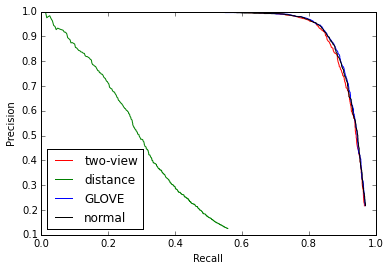

In [103]:
cat = coco_insts.loadCats(id_cat)[0]['name']
print(cat)
plt.figure()
#plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
#
plt.gca().set_color_cycle(['red', 'green', 'blue', 'black'])

for k,v in results[id_cat].iteritems():
    print k
    plt.plot(v[0], v[1])

plt.legend(results[id_cat].keys(), loc='best')
plt.savefig('plots/'+cat+'-precision_recall-MultipleView.png', bbox_inches='tight')
plt.show()

two-view
distance
GLOVE
normal


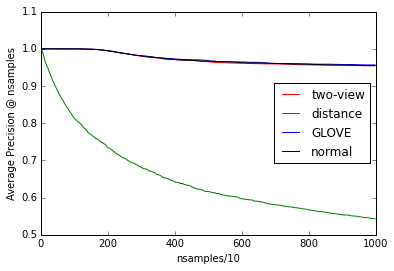

In [104]:

plt.figure()
#plt.plot(recall, precision)
plt.ylabel('Average Precision @ nsamples')
plt.xlabel('nsamples/10')
#plt.savefig('plots/'+cat+'-recall-precision-'+str(image_features)+'-'+str(reg)+'-'+str(n_components)+'-'+str(text_features)+'.png')
plt.gca().set_color_cycle(['red', 'green', 'blue', 'black'])

for k,v in results[id_cat].iteritems():
    print k
    plt.plot(range(len(v[2])), v[2])

plt.legend(results[id_cat].keys(), loc='best')
plt.savefig('plots/'+cat+'-average_precision-MultipleView.png', bbox_inches='tight')
plt.show()

## Perform I2T

In [75]:
imgIds[80691]

127643

A dog rides a skateboard down a sidewalk. 
A bull dog with a bandana rides a skateboard.
A dog is riding on a black skateboard with maroon wheels.
A dog wearing a bandana rides a skateboard.
A brown dog standing on top of a skateboard.


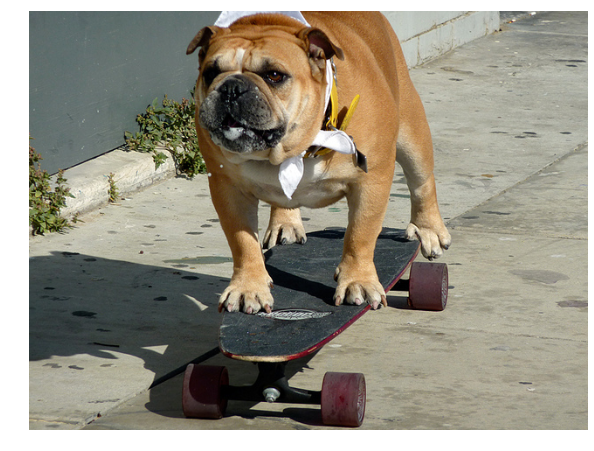

[u'dog', u'skateboard']


In [76]:
# choose an image, display chosen image
id_query = imgIds.index(127643)

img = coco_caps.loadImgs(imgIds[id_query])[0]

annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)

I = io.imread('images/%s/%s'%(dataType,img['file_name']))
coco_caps.showAnns(anns)
plt.figure(figsize=(10, 10)); plt.axis('off')
plt.imshow(I)
plt.show()
print(dic_img_cat[imgIds[id_query]])

In [77]:
indexes = [127643]
for index_image in indexes:
    print indexes
    id_query = imgIds.index(index_image)
    closest_ids = cca.I2T(id_query, image_features,IMAGES_PATH, neighbors_number = 100, cat = False, method = 'distance')

    true_positive = 0
    for closest_id in closest_ids:
        #img = coco_caps.loadImgs(imgIds[closest_id])[0]
        good = False
        #annIds = coco_caps.getAnnIds(imgIds=img['id']);
        #anns = coco_caps.loadAnns(annIds)
        for cat in dic_img_cat[imgIds[id_query]]:
            if cat in dic_img_cat[imgIds[closest_id]]:
                good = True
        if good:
            true_positive+=1
        

        #I = io.imread('%s/images/%s/%s'%(homePath,dataType,img['file_name']))
        #Iarray.append(I)
        #coco_caps.showAnns(anns)
        #plt.figure(); plt.axis('off')
        #plt.imshow(I)
        #plt.show()
    print float(true_positive)/100

[127643]
0.98
